# Make a complete ON-OFF analysis of a source

Sometimes, in the absence of availible IRFs, or for the detection of large extended sources filling the whole field of view, ON-OFF analysis is performed where the background is estimated from dedicated off observations, and wstat statistics used to compute the source significance. This notebook shows an example of the same.

## Imports

In [1]:
import sys, logging
import numpy as np
import astropy
import regions
import matplotlib.pyplot as plt
import astropy.units as u


In [2]:
#ignore repeated warnings while encountering 0 in wstat
import warnings
warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    module="gammapy"
)

In [21]:
from gammapy.data import DataStore, EventList
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
    MapDatasetOnOff,
    MapDataset
)
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.makers import (
    SafeMaskMaker,
    MapDatasetMaker
    )
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator


In [4]:
log = logging.getLogger(__name__)

## Data preparation

The most critical part of an on-off analysis to create the on-off run pairs.
The pairs must be "taken under similar observation conditions", and can be assumed to have the same IRFs. In this example, we have pre-created some on-off run pairs corresponding to similar zenith angles for MSH 15-52 runs in the HESS DL3 DR1. In reality, a simple zenith angle matching might not suffice and other conditions (eg: night sky background, telescope conditions, etc), might be needed to be accounted for as well. 

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [6]:
onoff_list = np.array(
    [
        [20136, 20734], 
              [20151, 20275], 
              [20282, 20275], 
              [20283, 20275], 
              [20301, 20275], 
              [20302, 20275], 
              [20303, 20275], 
              [20322, 20275], 
              [20323, 20275], 
              [20324, 20275], 
              [20325, 20275], 
              [20343, 20275], 
              [20344, 20275], 
              [20345, 20275], 
              [20346, 20275], 
              [20365, 20275], 
              [20366, 20275], 
              [20367, 20275], 
              [20368, 20275], 
              [11111, 22222], #dummy pair to be rejected 
             ])

In [7]:
# Remove runs not present in the datastore
on_obs_ids = []
off_obs_ids = []
for pair in onoff_list:
    status = True
    on, off = pair[0], pair[1]
    try:
        data_store.obs(on)
        try:
            data_store.obs(off)
            on_obs_ids.append(on)
            off_obs_ids.append(off)
        except:
            status = False
    except:
        status = False
        
    if status is False:
        print(f"Removing run pair {on}-{off}")

Removing run pair 11111-22222


In [8]:
on_observations = data_store.get_observations(on_obs_ids, skip_missing=False)
off_observations = data_store.get_observations(off_obs_ids, skip_missing=False)

In [9]:
#visualise the pairs
def visualise_obs(on_observations, off_observations):
    for obs_on, obs_off in zip(on_observations, off_observations):
        zen_on = np.round(obs_on.pointing_zen, 2)
        zen_off = np.round(obs_off.pointing_zen, 2)
        fig, ax = plt.subplots(1,2,figsize=(15,5))
        obs_on.events.plot_energy(ax[0])
        obs_off.events.plot_energy(ax[0])
        obs_on.aeff.plot_energy_dependence(ax=ax[1])
        obs_off.aeff.plot_energy_dependence(ax=ax[1])
        zen = np.round(obs_on.pointing_zen, 3)
        ax[0].set_title(f"{obs_on.obs_id} / {obs_off.obs_id}")
        ax[1].set_title(f"zen: {zen_on}/ {zen_off}")

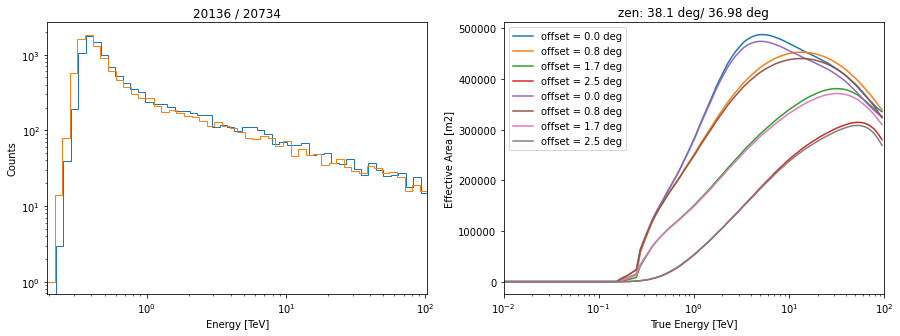

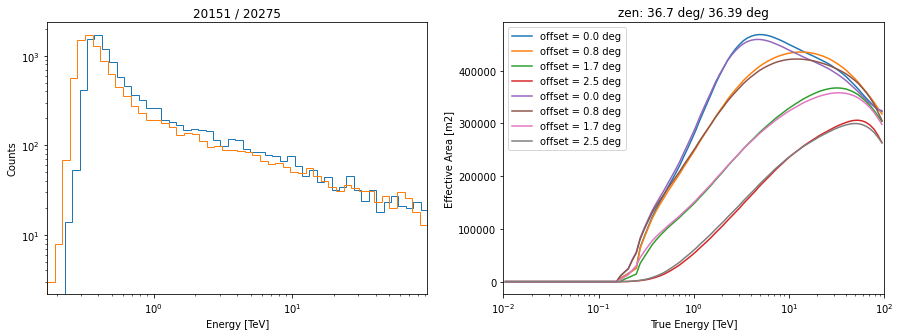

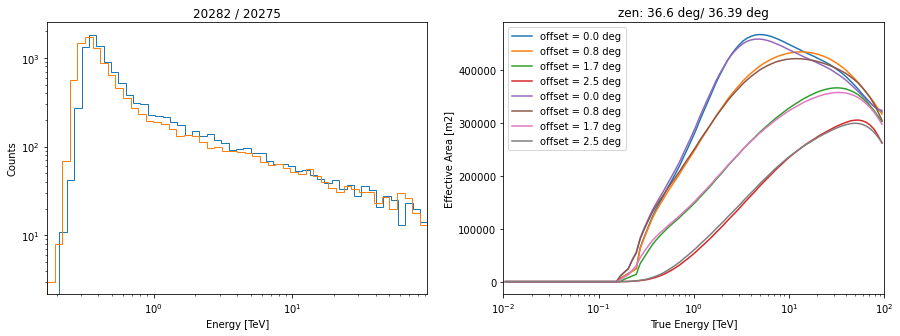

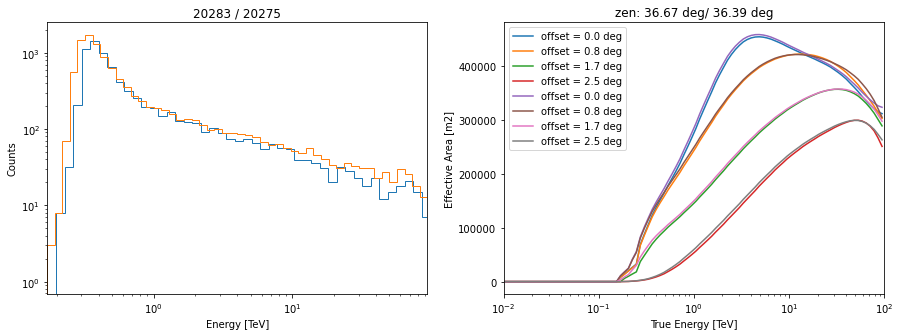

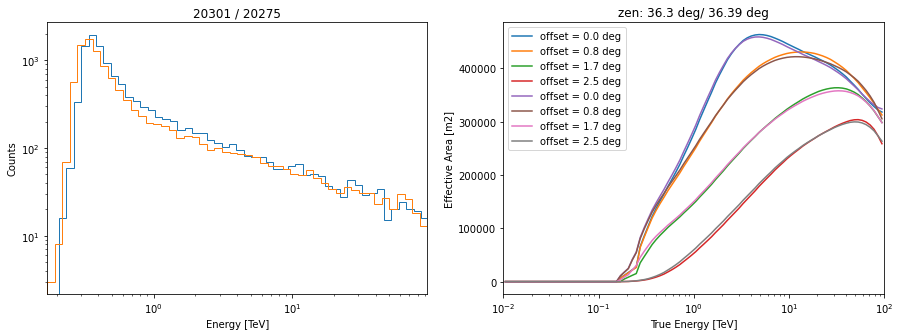

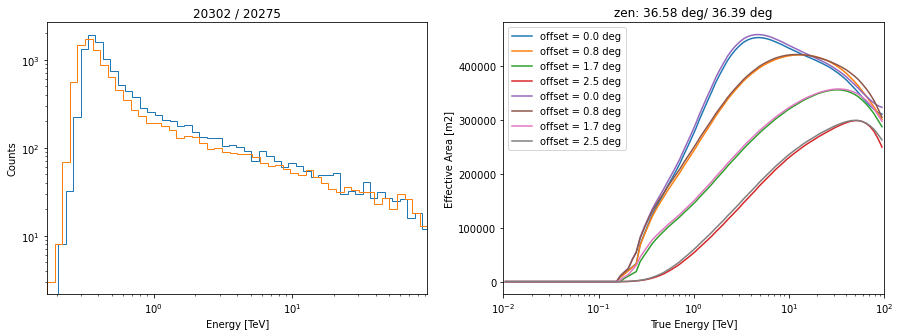

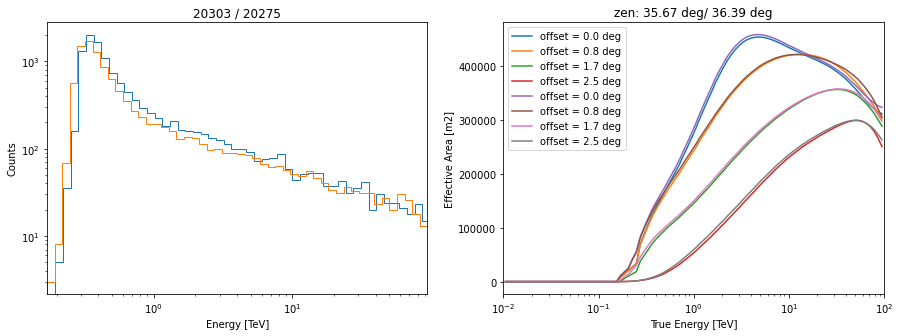

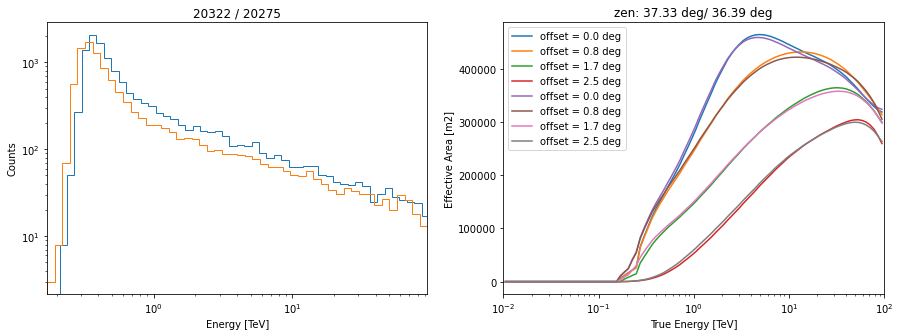

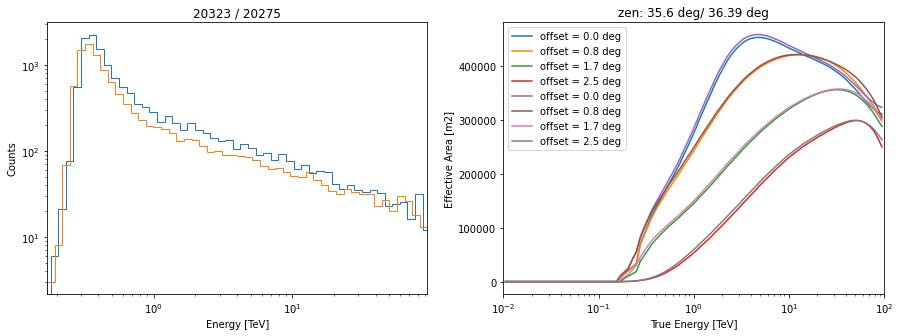

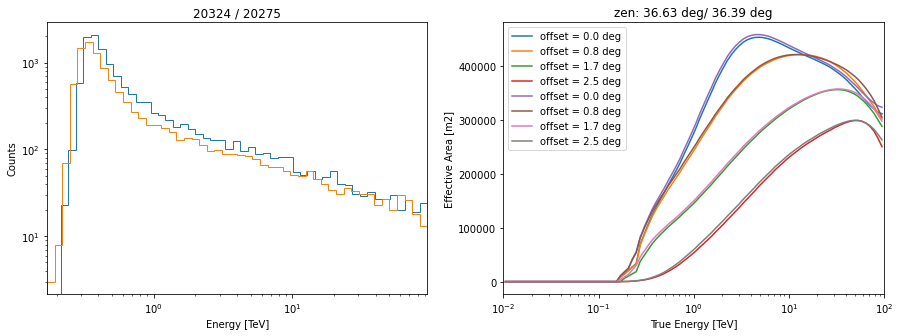

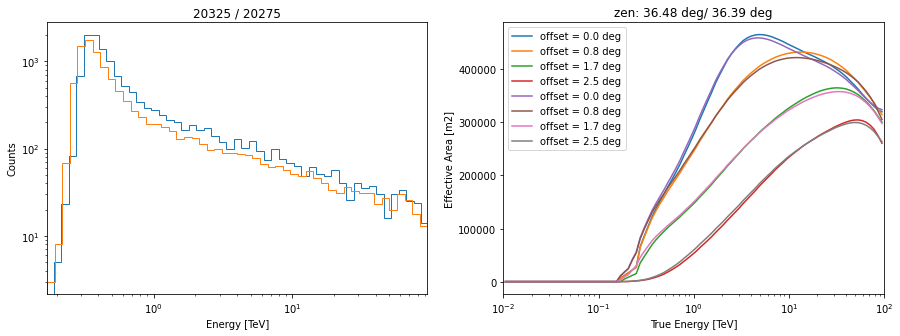

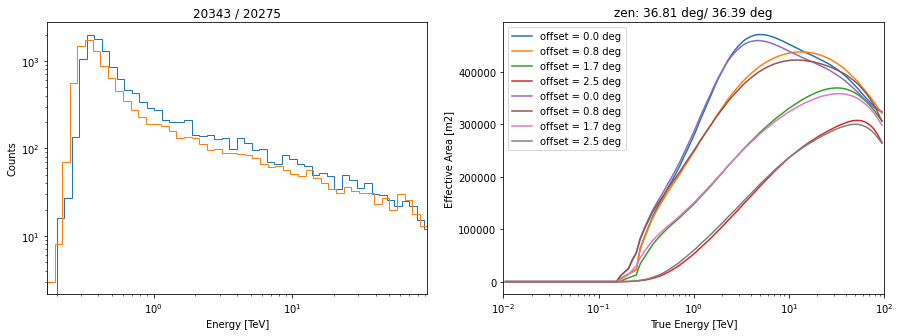

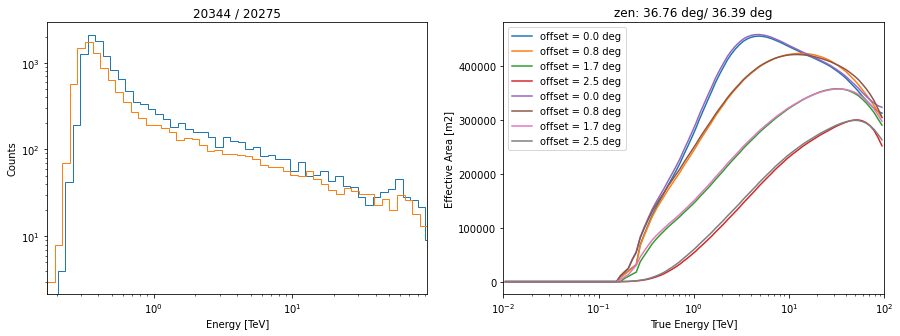

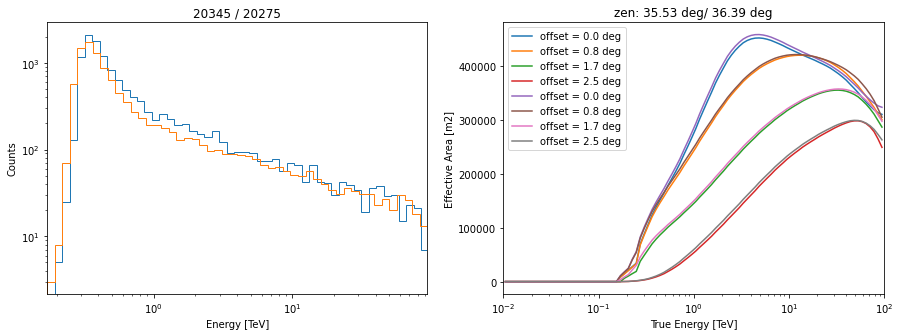

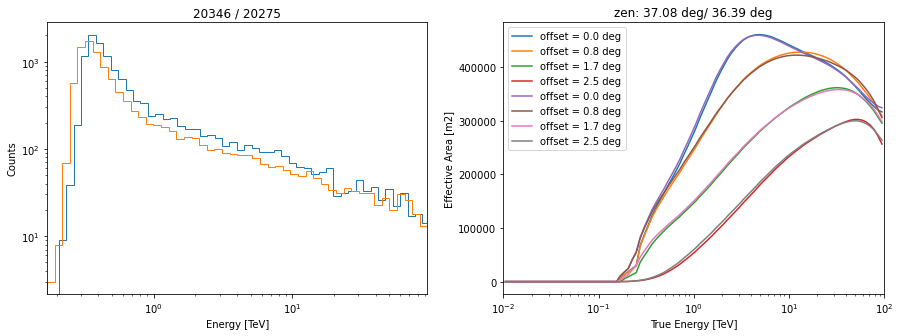

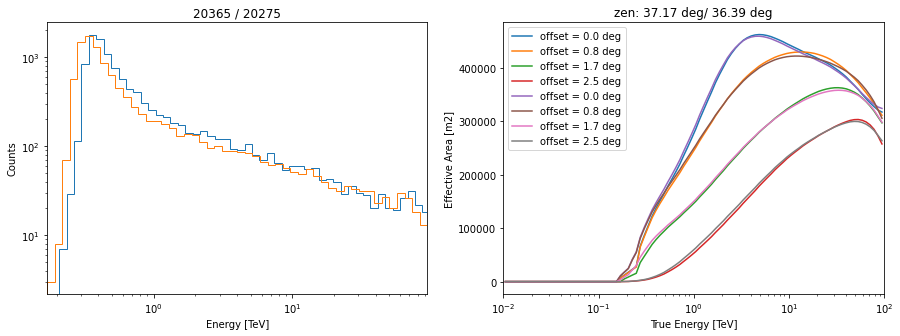

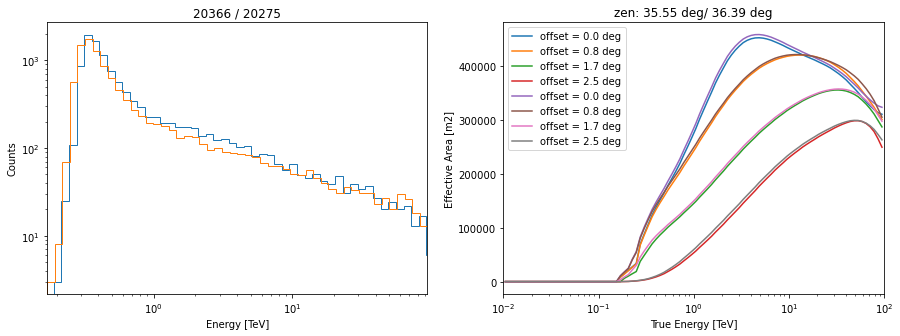

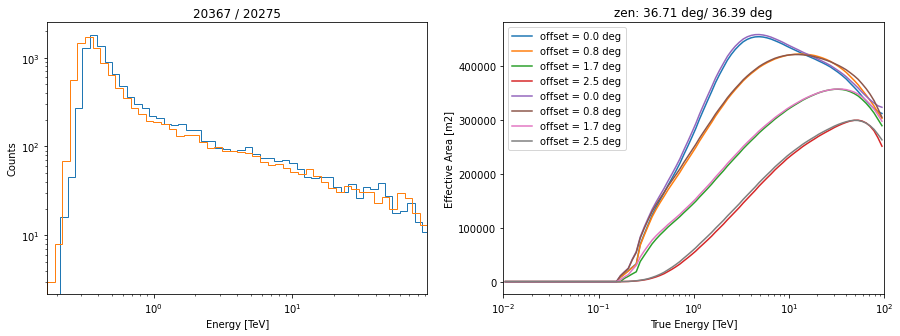

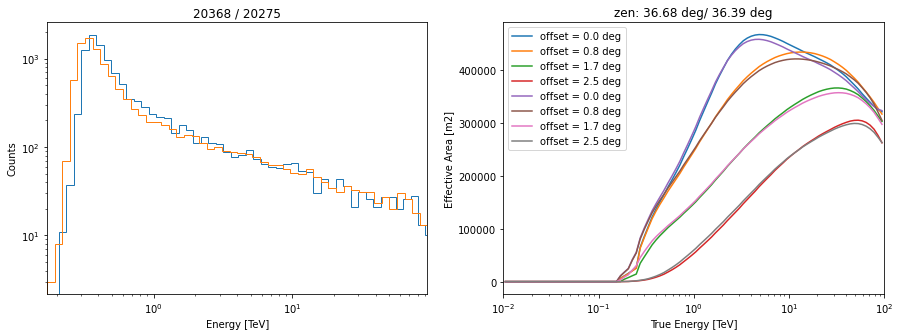

In [10]:
visualise_obs(on_observations, off_observations)

As you can see, the match is not ideal in many cases. For now, we proceed with this, but you might want to remove some more run pairs.

## Data reduction

We will now run the `MapDatasetMaker` to create the counts and the IRF maps.
If IRFs are not present for the production, then you should only create counts map and look at the significance maps for source detection.
In the present case, we also want to compute a spectrum in a given region, so binned IRFs are also computed. Background IRFs should not be constructed, as the off counts are computed from the OFF observations.
The off counts need to be reprojected on the the same frame as the ON observations.

In [22]:
#Functions to reproject OFF observations in the same frame as the ON observations
def create_on_off_dataset(dataset):
    """Create MapDatasetOnOff from an empty MapDataset."""
    counts_off = Map.from_geom(geom=dataset.counts.geom, unit='')
    acceptance = Map.from_geom(geom=dataset.counts.geom, data=1, unit='')
    acceptance_off = Map.from_geom(geom=dataset.counts.geom, data=1, unit='')
    
    return MapDatasetOnOff.from_map_dataset(dataset, acceptance, acceptance_off, counts_off)

In [23]:
def get_off_events(observation, off_observation):
    """Finds the OFF events in an OFF observation.
    
    The OFF events are obtained from the same FoV coordinates 
    in a system aligned with radec.
        
    Parameters:
    -----------
    observation : `Observation`
            ON observation.
    off_observation : `Observation`
            OFF observation.
 
    Return:
    -------
    off_region : `CircleSkyRegion`
        OFF region.
    """
    from gammapy.utils.coordinates import fov_to_sky, sky_to_fov

    
    events = off_observation.events
    
    fov_lon, fov_lat = sky_to_fov(
            events.radec.ra,
            events.radec.dec,
            off_observation.pointing_radec.ra,
            off_observation.pointing_radec.dec
    )
    off_ra, off_dec = fov_to_sky(
            fov_lon,
            fov_lat,
            observation.pointing_radec.ra,
            observation.pointing_radec.dec
    )

    off_coord = SkyCoord(off_ra, off_dec, frame='icrs')
    table = events.table.copy()
    table["RA"] = off_coord.ra
    table["DEC"] = off_coord.dec
    return EventList(table)

In [24]:
def make_on_off_mapdataset(observation, 
                           off_observation, 
                           dataset, 
                           normalise="livetime",
                          exclusion_mask=None):
    """Creates ON OFF dataset from an ON and a OFF observation.
    
        OFF region is taken at the same position in FoV coordinate
        system aligned with radec.
        
    Parameters:
    -----------
    observation : `Observation`
            ON observation.
    off_observation : `Observation`
            OFF observation.
    dataset : `MapDataset`
        ON map dataset.
    normalise : method to normalise the on and off counts. The supported methods are
        "livetime" : The difference of the two observation livetimes
        "exc_reg" : The number of counts outside the exclusion region (region must be supplied)


    Return:
    -------
    dataset_on_off : `SpectrumDatasetOnOff`
        On off dataset.
    """
    counts_off = Map.from_geom(dataset.counts.geom, unit='')
    events_off = get_off_events(observation, off_observation)

    counts_off.fill_events(events_off)
    
    if normalise == "livetime":
        acceptance = observation.observation_live_time_duration.to_value("s")
        acceptance_off = off_observation.observation_live_time_duration.to_value("s")
    
    elif normalise == "exc_reg":
        if exclusion_mask is None:
            raise ValueError("Exclusion region must be supplied for exc_reg method")
        acceptance = np.sum(dataset.counts * exclusion_mask)
        acceptance_off = np.sum(counts_off * exclusion_mask)
    else:
        raise ValueError("Normalisation method not supported")
        
    
    return MapDatasetOnOff.from_map_dataset(
            dataset=dataset,
            acceptance = Map.from_geom(
                dataset.counts.geom, 
                data=acceptance
            ),
            acceptance_off = Map.from_geom(
                dataset.counts.geom, 
                data=acceptance_off
            ),
            counts_off = counts_off
    )

Define the analysis geometery and the makers.
If IRFs are not present, an `energy_axis_true` is unnecessary.

In [25]:

source_pos = SkyCoord(320.29, -1.072, unit="deg", frame="galactic")
energy_axis = MapAxis.from_energy_bounds(0.6, 20, 10, unit="TeV",
                                         name="energy", 
                                         per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds(0.1, 100, 
                                              20, 
                                              unit="TeV",
                                              name="energy_true", 
                                              per_decade=True)


geom = WcsGeom.create(
        skydir=source_pos,
        binsz=0.02,
        width=(3, 3),
        frame="galactic",
        axes=[energy_axis],
)
dataset_empty = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [26]:

dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp","psf"])
safe_mask_masker = SafeMaskMaker(methods=["offset-max"], offset_max=2.1*u.deg)

In [27]:
stacked = create_on_off_dataset(dataset_empty)

In [28]:
exc_region = CircleSkyRegion(source_pos,
                            radius=0.5*u.deg)
exclusion_mask = geom.region_mask(exc_region, inside=False)


In [29]:
#Run the data reduction loop
# Here, we normalise using counts outside the exclusion region
for observation, off_observation in zip(on_observations, off_observations):
    obs_id = observation.obs_id
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = make_on_off_mapdataset(observation, 
                                            off_observation, 
                                            dataset, 
                                           normalise="exc_reg",
                                           exclusion_mask=exclusion_mask)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    dataset_on_off.exposure = dataset.exposure
    dataset_on_off.edisp = dataset.edisp
    dataset_on_off.psf = dataset.psf
    stacked.stack(dataset_on_off)

In [30]:
print(stacked)

MapDatasetOnOff
---------------

  Name                            : YIIygOpJ 

  Total counts                    : 29413 
  Total background counts         : 28868.64
  Total excess counts             : 544.36

  Predicted counts                : 29168.56
  Predicted background counts     : 29168.56
  Predicted excess counts         : nan

  Exposure min                    : 1.31e-02 m2 s
  Exposure max                    : 1.29e+10 m2 s

  Number of total bins            : 360000 
  Number of fit bins              : 359472 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 66073.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 21585 
  Acceptance                      : 360000 
  Acceptance off                  : 269304 



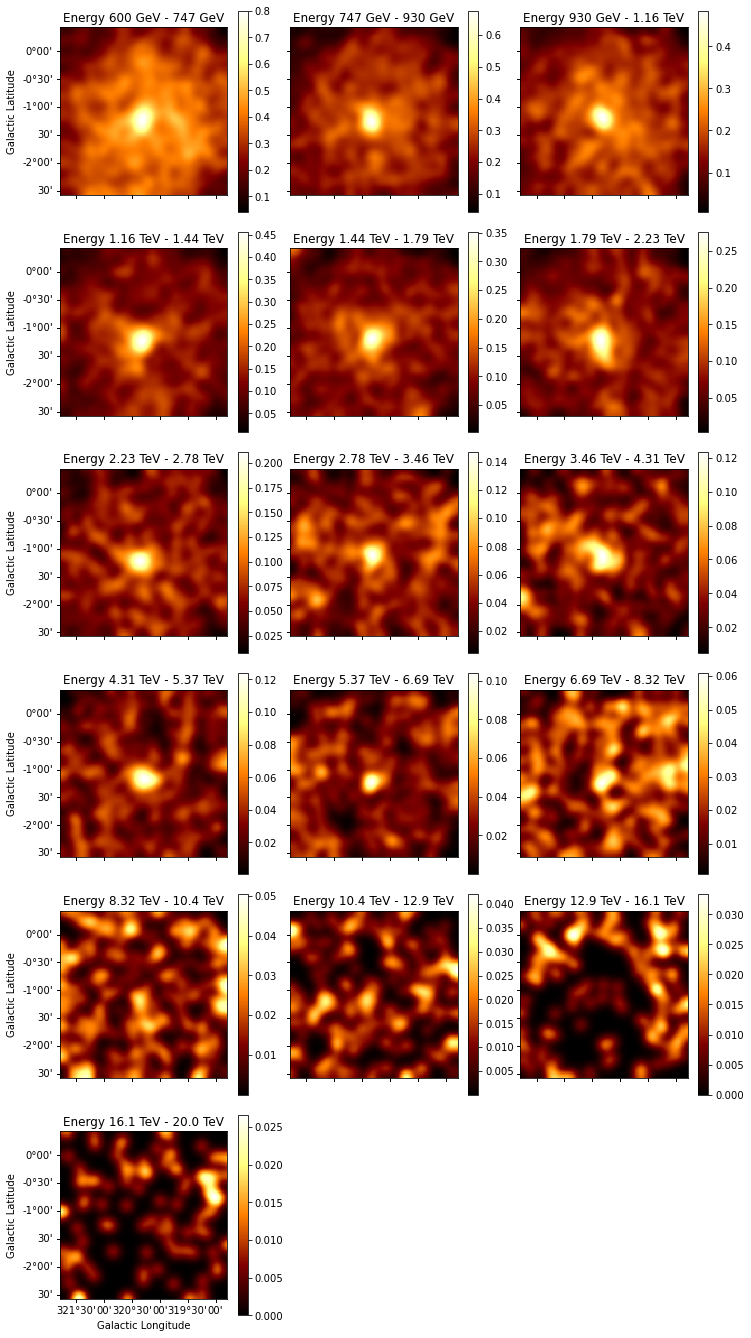

In [31]:
stacked.counts.smooth(0.1*u.deg).plot_grid(add_cbar=True);

## Compute the significance maps

In [32]:
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg, 
                               energy_edges=[0.6, 2.0, 20.0]*u.TeV, 
                               selection_optional=None)

res=estimator.run(stacked)

/Users/ASinha/opt/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


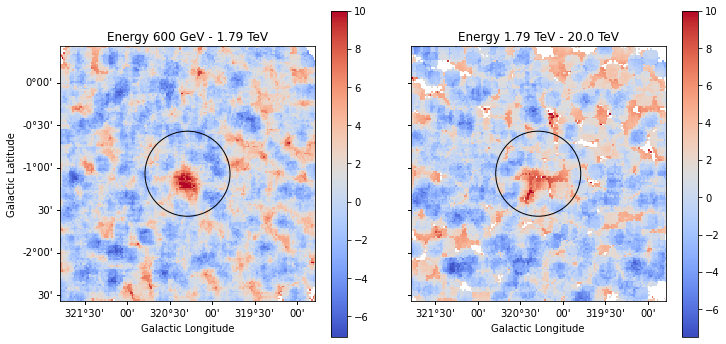

In [33]:
ax1, ax2 = res["sqrt_ts"].plot_grid(add_cbar=True, cmap="coolwarm", vmax=10)
exc_region.to_pixel(ax1.wcs).plot(ax=ax1)
exc_region.to_pixel(ax2.wcs).plot(ax=ax2)

## Spectrum extraction in a given on-region

In [34]:
on_region = CircleSkyRegion(source_pos,
                            radius=0.3*u.deg)
spectrum_dataset = stacked.to_spectrum_dataset(on_region)

/Users/ASinha/opt/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


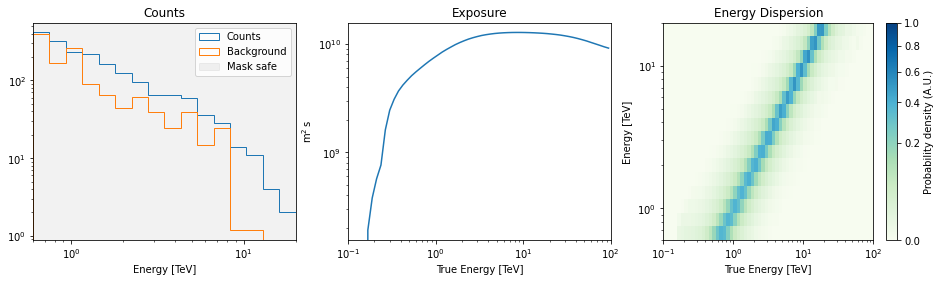

In [35]:
spectrum_dataset.peek()

In [36]:
spectral_model = PowerLawSpectralModel()
sky_model = SkyModel(spectral_model=spectral_model, name="spectral_msh")

In [37]:
spectrum_dataset.models = sky_model

In [38]:
fit = Fit()
result_spectral = fit.run([spectrum_dataset])

In [39]:
print(result_spectral)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 83
	total stat : 58.54

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [40]:
result_spectral.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.1238e+00,,8.937e-02,nan,nan,False,False,
spectral,amplitude,5.3655e-12,cm-2 s-1 TeV-1,5.421e-13,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


### Get flux points

In [41]:
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.downsample(2).edges,
    source="spectral_msh", 
    selection_optional="all"
)
flux_points = fpe.run(datasets=[spectrum_dataset])

<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2 * dnde [erg / (cm2 s)]'>

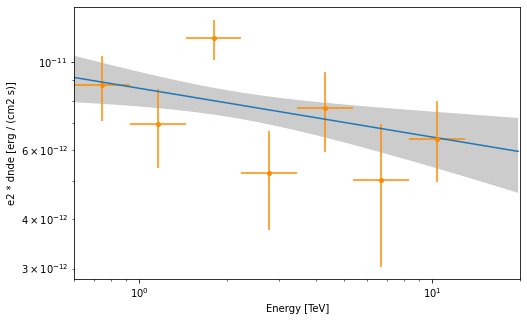

In [42]:
plt.figure(figsize=(8, 5))
ax = flux_points.plot(sed_type="e2dnde", color="darkorange")
spectral_model.plot(ax=ax, energy_power=2, energy_bounds=[0.5,20]*u.TeV)
spectral_model.plot_error(ax=ax, energy_power=2, energy_bounds=[0.5,20]*u.TeV)

We get a detection and a spectrum compatibe with the published results for `MSH 15 52` using the on-off method. This method must be used with caution for any reasonable analysis. 